### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle
from WeightedLDA import WeightedLDA
from shapeGMMTorch import similarities 
from shapeGMMTorch import plots

### load trajectory

In [2]:
data_path = "../iter-2/run_metad_sim/height_0.7_bf_8_sigma_0.55/analysis/"

# select atoms
sel_atoms = "(name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)"
print("selected atoms:", sel_atoms)

prmtopFileName =  data_path + "left_protein_only.gro"
trajFiles = [data_path + "wt_metad_ld1_aib9_400K_height_0.7_bf_8_sigma_0.55_wrapped.xtc"]
print(trajFiles)

coord = md.Universe(prmtopFileName,trajFiles)
bb_atoms = coord.select_atoms(sel_atoms)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",bb_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,bb_atoms.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = bb_atoms.positions - bb_atoms.center_of_geometry()
    count += 1

selected atoms: (name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)
['../iter-2/run_metad_sim/height_0.7_bf_8_sigma_0.55/analysis/wt_metad_ld1_aib9_400K_height_0.7_bf_8_sigma_0.55_wrapped.xtc']
Number of atoms in trajectory: 129
Number of frames in trajectory: 500001
Number of atoms being analyzed: 23
Number of frames being analyzed: 500001


In [3]:
print(data_path)

../iter-2/run_metad_sim/height_0.7_bf_8_sigma_0.55/analysis/


### load from COLVAR

In [4]:
#time, ld1, metad_rbias = np.loadtxt(data_path+"../COLVAR", usecols=(0,1,3), unpack=True)
time, ld1, metad_rbias = np.loadtxt(data_path+"../COLVAR_500ns", usecols=(0,1,3), unpack=True)

time *= 1e-3 # in ns
zeta = np.loadtxt(data_path+"zeta.txt")

#wall_bias = np.sum(np.loadtxt(data_path+"../COLVAR", usecols=(-2,-1)), axis=1)
wall_bias = np.sum(np.loadtxt(data_path+"../COLVAR_500ns", usecols=(-2,-1)), axis=1)

### plot the bias 

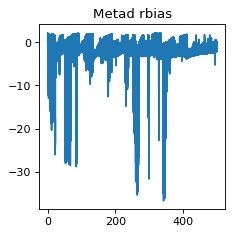

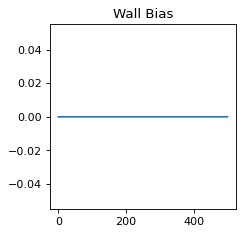

In [5]:
plt.figure(figsize=(3,3), dpi=80)
plt.title("Metad rbias", fontsize=12)
plt.plot(time, metad_rbias)

plt.figure(figsize=(3,3), dpi=80)
plt.title("Wall Bias", fontsize=12)
plt.plot(time, wall_bias)

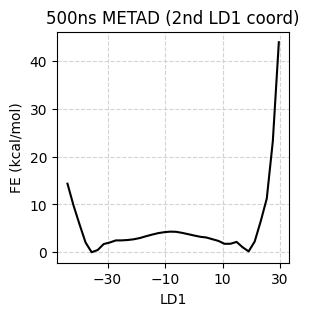

In [6]:
kbt = 0.794882 # from PLUMED at 400.0K
num_bins = 50
range_ = [-45,60]

# histogram
hist, edges = np.histogram(ld1, bins=num_bins, range=range_, density=True, weights=np.exp(metad_rbias/kbt))
bins = (edges[1:]+edges[:-1])/2
fe = -kbt*np.log(hist)
fe -= fe.min()

# plot
plt.figure(figsize=(3,3))
plt.title("500ns METAD (2nd LD1 coord)")
plt.ylabel("FE (kcal/mol)")
plt.xticks(np.arange(-50,70, 20))
plt.xlabel("LD1")
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
plt.plot(bins, fe, 'k-')

### plot LD and $\zeta$

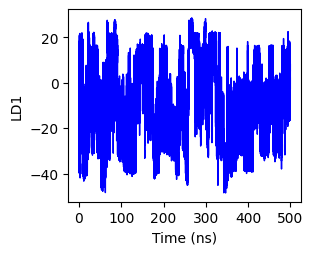

In [7]:
plt.figure(figsize=(3,2.5))
plt.xticks(np.arange(0,600,100))
plt.xlabel("Time (ns)")
plt.ylabel("LD1")
plt.plot(time, ld1, 'b-', lw=1.0)

In [8]:
print(min(ld1), max(ld1))
print(trajData.shape, metad_rbias.shape, ld1.shape, time.shape, zeta.shape)

-48.52602951 28.52400512
(500001, 23, 3) (500001,) (500001,) (500001,) (500001,)


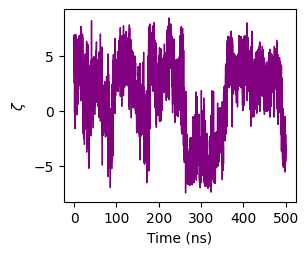

In [9]:
plt.figure(figsize=(3,2.5))
plt.xticks(np.arange(0,600,100))
plt.xlabel("Time (ns)")
plt.ylabel("$\zeta$")
plt.plot(time, zeta, ls="-", color="purple", lw=1.0)

### select the data and calculate weights

In [10]:
stride_ = 5  ## every 5 frame

trajData = trajData[::stride_,:,:]
time = time[::stride_]
metad_rbias = metad_rbias[::stride_]
ld1 = ld1[::stride_]
zeta = zeta[::stride_]

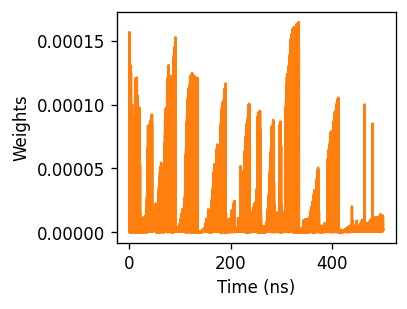

In [11]:
kt = 0.794882 # from PLUMED at 400.0K
weights = np.exp(metad_rbias/kt)  ## wall_bias = 0.0 for all chosen frames i.e. why not included
weights /=  np.sum(weights)

plt.figure(figsize=(3,2.5), dpi=120)
plt.xlabel("Time (ns)")
plt.ylabel("Weights")
plt.plot(time, weights, '-', color="tab:orange")

### perform cluster scan 

In [12]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)
print(cluster_array)

[2 3 4 5 6 7]


In [13]:
# perform cluster scan on this data (use 90% data for training)
#train, cv = scripts.cross_validate_cluster_scan(trajData, 90000, frame_weights = weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

# save the files
#np.savetxt("train.dat", np.column_stack((cluster_array, train)))
#np.savetxt("cv.dat", np.column_stack((cluster_array, cv)))

Number of frames to train each model: 90000
Number of frames to predict each model: 10001
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               2               1              93.123          33.137
              1               2               2              93.262          36.351
              1               2               3              90.636          20.433
              1               2               4              92.483          41.460
              1               2               5              93.397          41.424
              1               2               6              93.121          40.617
              1               2               7              93.260          40.583
              1               2               8              93.1

              2               5               5             102.903          43.122
              2               5               6             101.484          73.817
              2               5               7             103.790          41.807
              2               5               8             101.404          29.181
              2               5               9             101.692          66.148
              2               5              10             103.218          58.653
              2               6               1             104.715          51.432
              2               6               2             104.022          30.963
              2               6               3             102.751         105.268
              2               6               4             104.484          64.787
              2               6               5             105.446         101.630
              2               6               6             105.067         

              4               3               3              96.572          37.969
              4               3               4              96.668          57.632
              4               3               5              96.308          48.634
              4               3               6              96.448          58.113
              4               3               7              95.011          56.650
              4               3               8              97.783          40.683
              4               3               9              96.512          53.328
              4               3              10              98.517          42.558
              4               4               1             100.241          62.873
              4               4               2             102.260          44.613
              4               4               3              98.340          49.829
              4               4               4             100.946         

In [13]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

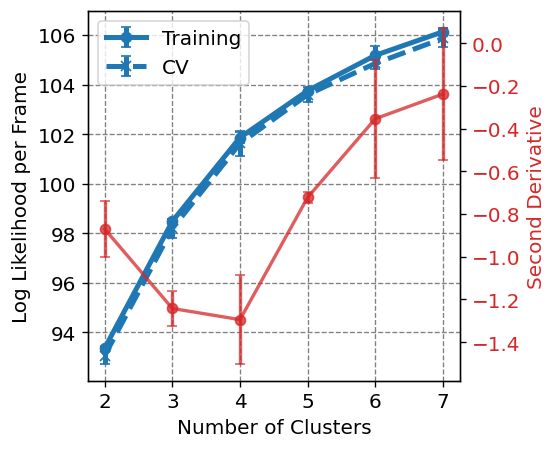

In [14]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plots.plot_log_likelihood_with_dd(ax,cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=True, xlabel=True)

## 3 clusters

In [15]:
#wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_3states.pickle", "wb")as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              97.469          37.978
       2              95.573          47.562
       3              96.206          60.650
       4              96.217          63.283
       5              96.801          65.493
       6              96.640          61.036
       7              95.554          24.495
       8              96.450          64.066
       9              97.459          42.870
      10              96.208          58.711
      11              95.972          60.369
      12              98.364          33.862
      13              96.643          55.853
      14              97.746          50.082
      15              96.456          58.927
      16              97.464          40.563
      17              98.331          50.054
      18              96.714          55.229
      19       

## 4 clusters

In [16]:
#wsgmm = scripts.sgmm_fit_with_attempts(trajData, 4, 20, weights, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_4states.pickle", "wb")as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 100001
Number of clusters: 4
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              99.983          33.561
       2             101.200          44.490
       3             100.199          64.410
       4             100.313          62.574
       5              99.516          76.001
       6             101.084          71.422
       7             100.558          36.034
       8             101.040          55.050
       9              98.426          49.684
      10              99.090          66.636
      11              98.574          64.817
      12             101.071          26.879
      13              99.017          48.493
      14              98.173          66.010
      15             100.694          71.271
      16             100.581          60.358
      17             101.272          55.107
      18              98.362          67.442
      19       

### load all the objects 

In [15]:
wsgmm_list = []
for i in [3,4]:
    with open("wsgmm_%dstates.pickle"%i, "rb") as fo:
        wsgmm = pickle.load(fo)
    wsgmm_list.append(wsgmm)

In [16]:
print(wsgmm_list[0].weights)
print(wsgmm_list[0].cluster_ids.shape)

print(wsgmm_list[1].weights)
print(wsgmm_list[1].cluster_ids.shape)

[0.46438922 0.2805976  0.25501318]
(100001,)
[0.40892429 0.25975676 0.18921579 0.14210316]
(100001,)


### Check the bhattacharya distances for cluster centers w.r.t. initial clusters

$\textbf{load initial object from wt-metad of posLDA paper}$

c= 0 is left helix and c= 1 is right helix.

In [17]:
path_to_ref_gmm = "/scratch/projects/hockygroup/ss12902/aib9_sGMM_torch/"
with open(path_to_ref_gmm+"wsgmm.pickle", "rb") as fo:
    wsgmm_ref = pickle.load(fo)

In [18]:
dist_data = []

# loop over objects [3,4]
for i in range(2):
    
    vals = []
    # loop over number of clusters
    for j in range(wsgmm_list[i].n_clusters):
        
        # wrt 0
        dij_0 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 0)
        
        # wrt 1
        dij_1 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 1)
        
        vals.append([dij_0, dij_1])
        
    #dist_data.append(np.array(vals))
    dist_data.append(np.log(np.array(vals)))     # take log y

In [19]:
print(dist_data)

[array([[0.49960358, 6.34893079],
       [5.74754119, 1.18587981],
       [2.24056608, 2.48304926]]), array([[-0.93623784,  6.92198278],
       [ 2.09189178,  2.41459771],
       [ 7.0769303 , -3.37394573],
       [ 2.27252267,  2.41291336]])]


In [20]:
# save log(b-dist) data
np.savetxt('logb-dist.txt', dist_data[1])

### 3 clusters

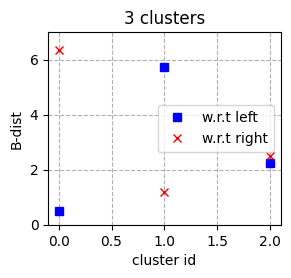

In [22]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("3 clusters")
plt.ylim(0,7)
wsgmm3 = wsgmm_list[0]
for i in range(wsgmm3.n_clusters):
    x = plt.plot(i, dist_data[0][i,0], 's', color="b", label="w.r.t left" if i == 0 else "")
    y = plt.plot(i, dist_data[0][i,1], 'x', color="r", label="w.r.t right" if i == 0 else "")
plt.legend()

4.350003944320655
-3.858575668736039
0.8280384093905767


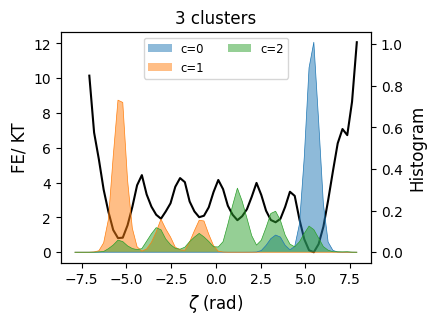

In [23]:
wsgmm3 = wsgmm_list[0]

range_ = [-8.0,8.0]
nbins = 60
hist, edges = np.histogram(zeta, range=range_, bins=nbins, density=True, weights=weights)
bins = (edges[1:]+edges[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()

fig, ax =plt.subplots(1, 1, figsize=(4,3))
plt.title("3 clusters")
ax.set_ylabel("FE/ KT", fontsize=12)
ax.set_xlabel("$\zeta$ (rad)", fontsize=12)
ax.plot(bins, fe, 'k-')
ax_inv  =ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    zeta_i = zeta[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]]
    print(np.mean(zeta_i))
    H, _ = np.histogram(zeta_i, range=range_, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]])
    ax_inv.fill_between(bins, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(bins, H, lw=0.5)
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

### 4 clusters

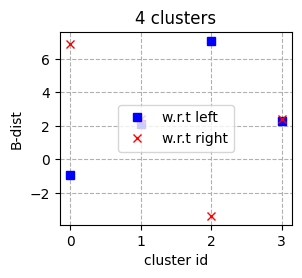

In [24]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("4 clusters")
#plt.ylim(-0.5,7.5)
wsgmm4 = wsgmm_list[1]
for i in range(wsgmm4.n_clusters):
    x = plt.plot(i, dist_data[1][i,0], 's', color="b", label="w.r.t left" if i == 0 else "")
    y = plt.plot(i, dist_data[1][i,1], 'x', color="r", label="w.r.t right" if i == 0 else "")
plt.legend(loc='center')

5.411599714561368
0.4878253060011933
-5.378344862535255
1.4596106256548007


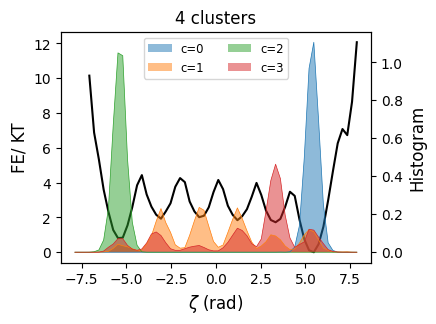

In [25]:
wsgmm4 = wsgmm_list[1]

range_ = [-8.0,8.0]
nbins = 60
hist, edges = np.histogram(zeta, range=range_, bins=nbins, density=True, weights=weights)
bins = (edges[1:]+edges[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()

fig, ax =plt.subplots(1, 1, figsize=(4,3))
plt.title("4 clusters")
ax.set_ylabel("FE/ KT", fontsize=12)
ax.set_xlabel("$\zeta$ (rad)", fontsize=12)
ax.plot(bins, fe, 'k-')
ax_inv  =ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(4):
    zeta_i = zeta[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]]
    print(np.mean(zeta_i))
    H, _ = np.histogram(zeta_i, range=range_, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]])
    ax_inv.fill_between(bins, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(bins, H, lw=0.5)
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

### Global Alignment of trajectory 

In [26]:
# load the global aligned traj -->
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)
print(global_aligned_traj.shape)

(100001, 23, 3)


### We are going to choose 3-state fit 

For 3 clusters ->
1. c=0 is closest to left state
2. c=1 is closest to right state 

In [33]:
c0_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 0)]   # left
c1_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 1)]   # right 

print(len(c0_indx), len(c1_indx))

27104 7490


In [35]:
c0_traj = global_aligned_traj[c0_indx,:,:]   # close to left
c1_traj = global_aligned_traj[c1_indx,:,:]   # close to right

comb_traj = np.concatenate([c0_traj, c1_traj], axis=0)
labels = np.concatenate([np.zeros(len(c0_indx)), np.ones(len(c1_indx))], axis=0)

print(comb_traj.shape, labels.shape)

(34594, 23, 3) (34594,)


### perform weighted LDA 

In [36]:
from WeightedLDA import WeightedLDA as WL

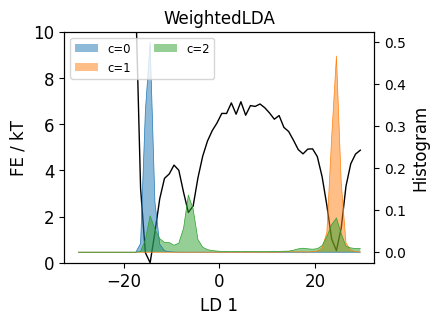

In [47]:
ld_range = (-30,30)
nbins = 60

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
ax.set_ylabel("FE / kT",fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_ylim(0,10.0)

# lda calculation
lda = WL.WeightedLDA()

# get weights for left and right helix only
sel_weights = np.concatenate([weights[c0_indx], weights[c1_indx]], axis=0)

lda.fit(comb_traj.reshape(comb_traj.shape[0], comb_traj.shape[1]*3), labels, wgts=sel_weights)
ld1_all = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=weights)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.0, color="k")

ax_inv = ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(3):
    ld_i = ld1_all[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]]
    H, _ = np.histogram(ld_i, range=ld_range, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper left", fontsize="small")

In [46]:
print(sel_weights.shape, comb_traj.shape)

(34594,) (34594, 23, 3)


In [48]:
print(kt)
print(max(ld1_all), min(ld1_all))

0.794882
65.94610329662564 -17.155986090214807


In [49]:
# save the lda coefficients
#np.savetxt("ld1_3states_scalings.txt", lda.scalings_[:,0])

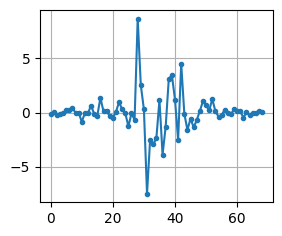

In [50]:
plt.figure(figsize=(3,2.5))
plt.grid()
plt.plot(lda.scalings_[:,0], '.-')

In [51]:
# calculating the standard deviation of LD coord from left helical state 
print(np.std(ld1_all[c0_indx]))
print(np.std(ld1_all[c0_indx])/2)
print(np.std(ld1_all[c0_indx])/3)

0.7642053584312323
0.38210267921561614
0.25473511947707744


In [52]:
print(bb_atoms.indices+1)

[ 18  20  22  31  33  35  44  46  48  57  59  61  70  72  74  83  85  87
  96  98 100 109 111]


### We have to try using 4-state fit also -->

$\textbf{Reason}$: The LD1 coordinate obtained from 3 state is not stable when biased in metad simulation. Also if we look at the overlap of histogram plot along zeta coordinate it is obvious that 4 state provides better definitions of the left and right helices. 

Also please not that here we have negative values for log(B-dist). 

For 4 clusters ->
1. c=0 is closest to left state
2. c=2 is closest to right state

In [62]:
c0_indx_4state = [x[0] for x in np.argwhere(wsgmm4.cluster_ids == 0)]   # left
c2_indx_4state = [x[0] for x in np.argwhere(wsgmm4.cluster_ids == 2)]   # right

print(len(c0_indx_4state), len(c2_indx_4state))

11808 4372


In [63]:
c0_traj_4state = global_aligned_traj[c0_indx_4state,:,:]   # close to left
c2_traj_4state = global_aligned_traj[c2_indx_4state,:,:]   # close to right

comb_traj_4state = np.concatenate([c0_traj_4state, c2_traj_4state], axis=0)
labels_4state = np.concatenate([np.zeros(len(c0_indx_4state)), np.ones(len(c2_indx_4state))], axis=0)

print(comb_traj_4state.shape, labels_4state.shape)

(16180, 23, 3) (16180,)


### perform weighted LDA for 4 state 

In [64]:
from WeightedLDA import WeightedLDA as WL

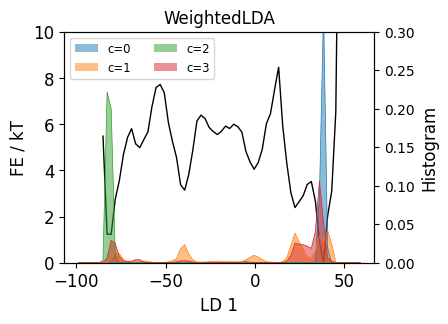

In [65]:
ld_range = (-100,60)
nbins = 70

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
ax.set_ylabel("FE / kT",fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)
ax.set_ylim(0,10.0)

# lda calculation
lda = WL.WeightedLDA()

# get weights for left and right helix only
sel_weights_4state = np.concatenate([weights[c0_indx_4state], weights[c2_indx_4state]], axis=0)

lda.fit(comb_traj_4state.reshape(comb_traj_4state.shape[0], comb_traj_4state.shape[1]*3), labels_4state, wgts=sel_weights_4state)
ld1_all_4state = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all_4state, range=ld_range, bins=nbins, density=True, weights=weights)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.0, color="k")

ax_inv = ax.twinx()
ax_inv.set_ylabel("Histogram", fontsize=12)
ax_inv.set_ylim(0.0,0.30)
for i in range(wsgmm4.n_clusters):
    ld_i = ld1_all_4state[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]]
    H, _ = np.histogram(ld_i, range=ld_range, bins=nbins, density=True, weights=weights[[x[0] for x in np.argwhere(wsgmm4.cluster_ids == i)]])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper left", fontsize="small")

In [66]:
print(min(ld1_all_4state), max(ld1_all_4state))
print(ld1_all_4state.shape)

-85.64756762534198 46.3010463101915
(100001,)


In [67]:
print(sel_weights_4state.shape, comb_traj_4state.shape)

(16180,) (16180, 23, 3)


In [68]:
# save the lda coefficients
np.savetxt("ld1_4states_scalings.txt", lda.scalings_[:,0])

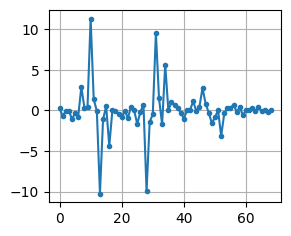

In [69]:
plt.figure(figsize=(3,2.5))
plt.grid()
plt.plot(lda.scalings_[:,0], '.-')

In [70]:
# calculating the standard deviation of LD coord from left helical state 
print(np.std(ld1_all_4state[c0_indx_4state]))
print(np.std(ld1_all_4state[c0_indx_4state])/2)
print(np.std(ld1_all_4state[c0_indx_4state])/3)

0.9956370149558913
0.49781850747794565
0.3318790049852971
